# Smoothened diffusivity at boundary

## Defining function

In [1]:
# Liberary
import numpy as np
from scipy.interpolate import CubicSpline
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Sympy function
import sympy
# sympy.init_printing()
z = sympy.symbols('z')

K0 = 1e-6
K1 = 6e-3  # m / s
Aalpha = 0.5
c = 10
w = 0

sym_Diffu = K0 + K1 * z * sympy.exp(-Aalpha * z) + K1/c*(1 - sympy.tanh(c*(z)))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu = sympy.utilities.lambdify(z, sym_Diffu, np)
dKdz = sympy.utilities.lambdify(z, sym_dKdz, np)
Beta = sympy.utilities.lambdify(z, sym_Beta, np)
dBdz = sympy.utilities.lambdify(z, sym_dBdz, np)
ddBdzz = sympy.utilities.lambdify(z, sym_ddBdzz, np)
Alpha = sympy.utilities.lambdify(z, sym_Alpha, np)
dAdz = sympy.utilities.lambdify(z, sym_dAdz, np)
ddAdzz = sympy.utilities.lambdify(z, sym_ddAdzz, np)
dABdz = sympy.utilities.lambdify(z, sym_Alpha * sym_Beta, np)

In [3]:
# SDE schemes
# Euler-Maruyama

def step_e(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    a = dKdz(z)
    b = np.sqrt(2 * Diffu(z))

    temp = z + a * dt + b * dW

    return temp
def step_e_const(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    K0 = 3e-3
    b = np.sqrt(2 * K0)

    temp = z + b * dW
    return temp
# Visser
def step_v(z, H, dt, N_sample):

    dW = np.random.uniform(-1, 1, N_sample)
    r = 1 / 3
    #dW=np.random.normal(0,np.sqrt(dt),N_sample)
    #r=dt

    a = dKdz(z)
    G = Diffu(z + a * dt / 2)

    temp = z + a * dt + np.sqrt(2 / r * dt * G) * dW
    return temp
def step_v_const(z, H, dt, N_sample):
    K0 = 3e-3

    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    r = dt

    temp = z + np.sqrt(2 / r * dt * K0) * dW
    return temp
# Milstein
def step_m(z, H, dt, N_sample):
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    #de=np.random.normal(dt,np.sqrt(dt),N_sample)
    #temp= z + (1/2)*dKdz(z)*(de+dt) + Beta(z)*dW

    temp = z + (1 / 2) * dKdz(z) * (dW * dW + dt) + Beta(z) * dW
    return temp
# Milstein 2 nd
def step_m2(z, H, dt, N_sample):
    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    k = Diffu(z)
    dkdz = dKdz(z)
    ddkdz = dAdz(z)
    dddkdz = ddAdzz(z)
    sqrt2k = np.sqrt(2 * k)

    a = dkdz
    da = ddkdz
    dda = dddkdz
    b = sqrt2k
    db = dkdz / b
    ddb = ddkdz / b - ((dkdz)**2) / b**3
    ab = da * b + a * db

    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2

    return temp

In [4]:
# Parallel functions

def oneStep(Z, scheme, H, dt):

    Z = scheme(Z, H, dt, Z.size)

    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2 * H - Z, Z)

    return Z

def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')

    z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0

    for i in range(Ntime):

        z = oneStep(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None

    quene.put(hist_)

    return None


def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)

    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()

    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * dz * (Ntime + 1))

    return hist_

#### $\Delta t = 0.1$ for all four schemes

In [5]:
#
Np = 20000
Nbins = 100
dt = 0.1
Tmax = dt * 24 * 3600
H = 10
Testdepth = 0.01
NumberOfThread = 4

E1 = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_e)
V1 = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_v)
M1 = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_m)
M2 = RunSimulation(NumberOfThread, Tmax, dt, H,
                                           Testdepth, Np, Nbins, step_m2)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4


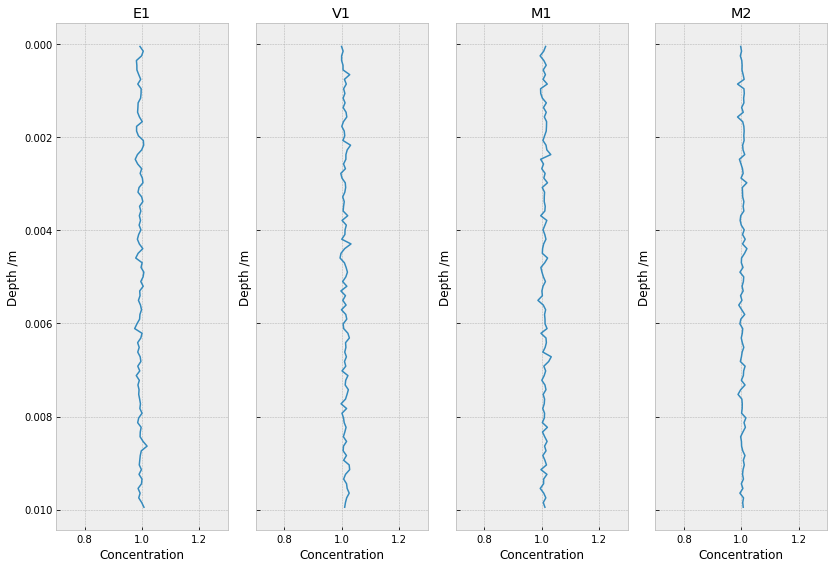

In [6]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2
fig, ax = plt.subplots(ncols=4, figsize=(11.69, 8), sharey=True)
ax[0].invert_yaxis()

ax[0].plot(E1, midpoints, linewidth=1.5, label="variable")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].set_xlim(0.7, 1.3)

ax[1].plot(V1, midpoints, linewidth=1.5, label="variable")
ax[1].set_xlabel('Concentration')
ax[1].set_ylabel('Depth /m')
ax[1].set_title('V1')
ax[1].set_xlim(0.7, 1.3)

ax[2].plot(M1, midpoints, linewidth=1.5, label="variable")
ax[2].set_xlabel('Concentration')
ax[2].set_ylabel('Depth /m')
ax[2].set_title('M1')
ax[2].set_xlim(0.7, 1.3)

ax[3].plot(M2, midpoints, linewidth=1.5, label="variable")
ax[3].set_xlabel('Concentration')
ax[3].set_ylabel('Depth /m')
ax[3].set_title('M2')
ax[3].set_xlim(0.7, 1.3)

plt.tight_layout()

## compare to orignal diffusivity profile

In [7]:
# Sympy function
import sympy
z = sympy.symbols('z')

K0 = 1e-6
K1 = 6e-3  # m / s
Aalpha = 0.5
c = 10
w = 0

sym_Diffu = K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu = sympy.utilities.lambdify(z, sym_Diffu, np)
dKdz = sympy.utilities.lambdify(z, sym_dKdz, np)
Beta = sympy.utilities.lambdify(z, sym_Beta, np)
dBdz = sympy.utilities.lambdify(z, sym_dBdz, np)
ddBdzz = sympy.utilities.lambdify(z, sym_ddBdzz, np)
Alpha = sympy.utilities.lambdify(z, sym_Alpha, np)
dAdz = sympy.utilities.lambdify(z, sym_dAdz, np)
ddAdzz = sympy.utilities.lambdify(z, sym_ddAdzz, np)
dABdz = sympy.utilities.lambdify(z, sym_Alpha * sym_Beta, np)

In [8]:
#
Np = 20000
Nbins = 100
dt = 0.1
Tmax = dt * 24 * 3600

H = 10
Testdepth = 0.01
NumberOfThread = 4

E1Old = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_e)
V1Old = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_v)
M1Old = RunSimulation(NumberOfThread, Tmax, dt, H,
                                          Testdepth, Np, Nbins, step_m)
M2Old = RunSimulation(NumberOfThread, Tmax, dt, H,
                                           Testdepth, Np, Nbins, step_m2)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4


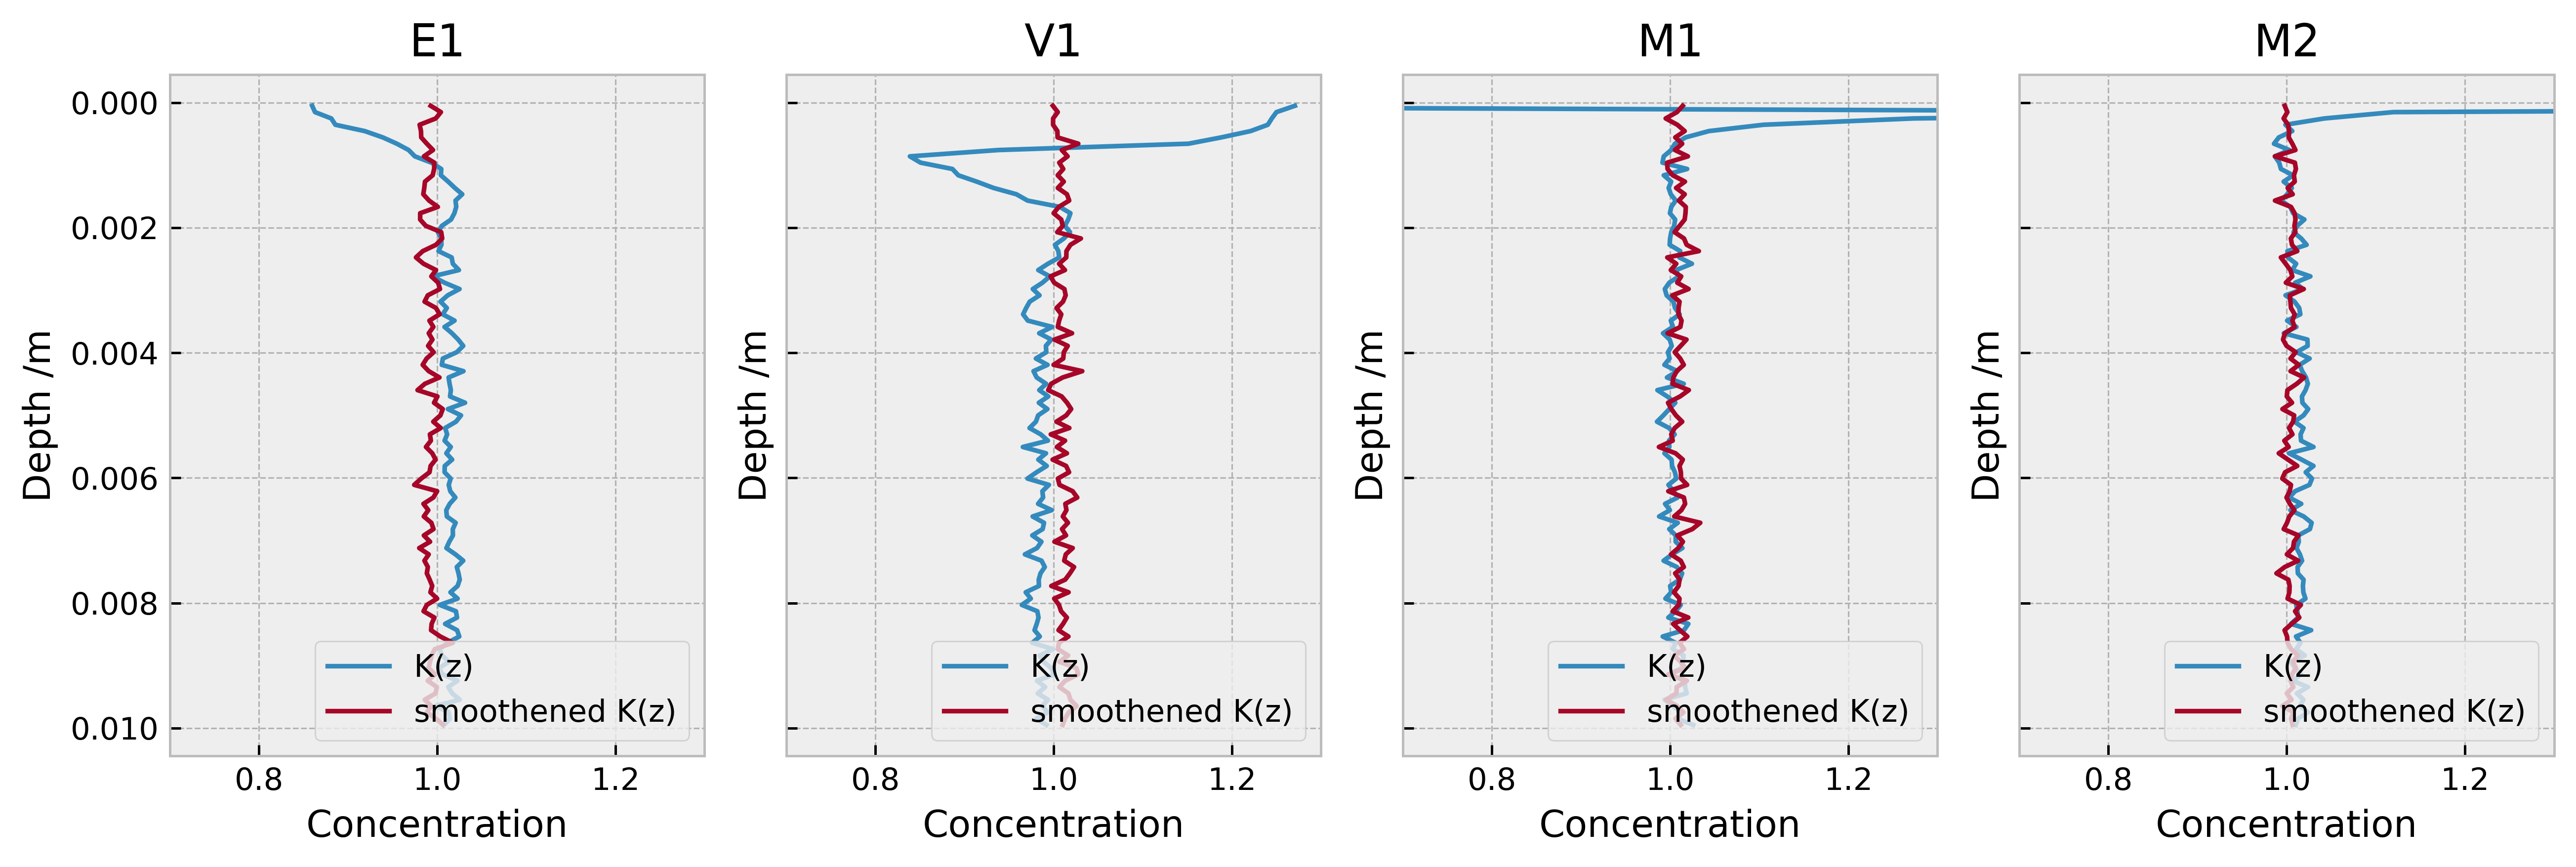

In [14]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2
fig, ax = plt.subplots(ncols=4, figsize=(11.69, 4), sharey=True, dpi = 450)
ax[0].invert_yaxis()

ax[0].plot(E1Old, midpoints, linewidth=1.5, label="K(z)")
ax[0].plot(E1, midpoints, linewidth=1.5, label="smoothened K(z)")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].set_xlim(0.7, 1.3)
ax[0].legend(loc=4)

ax[1].plot(V1Old, midpoints, linewidth=1.5, label="K(z)")
ax[1].plot(V1, midpoints, linewidth=1.5, label="smoothened K(z)")
ax[1].set_xlabel('Concentration')
ax[1].set_ylabel('Depth /m')
ax[1].set_title('V1')
ax[1].set_xlim(0.7, 1.3)
ax[1].legend(loc=4)

ax[2].plot(M1Old, midpoints, linewidth=1.5, label="K(z)")
ax[2].plot(M1, midpoints, linewidth=1.5, label="smoothened K(z)")
ax[2].set_xlabel('Concentration')
ax[2].set_ylabel('Depth /m')
ax[2].set_title('M1')
ax[2].set_xlim(0.7, 1.3)
ax[2].legend(loc=4)

ax[3].plot(M2Old, midpoints, linewidth=1.5, label="K(z)")
ax[3].plot(M2, midpoints, linewidth=1.5, label="smoothened K(z)")
ax[3].set_xlabel('Concentration')
ax[3].set_ylabel('Depth /m')
ax[3].set_title('M2')
ax[3].set_xlim(0.7, 1.3)
ax[3].legend(loc=4)

plt.tight_layout()

In [48]:
Tmax

8640.000000000002